[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/liapla/Game-Theory-and-Epidemics/blob/main/Recreation.ipynb)

## **In this notebook we will reproduce some plots of the "[Group interest versus self-interest in smallpox vaccination policy](https://www.pnas.org/doi/full/10.1073/pnas.1731324100)" paper. We define a SEIDV epidemic model for the smallpox and we use game theory to find the level of vaccination that will be achived, if the individuals decide to get vaccinated regarding their own interest and the vaccination level that assures herd immunity.**

#Importing libraries and plots initializations

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib as mpl

# Matplotlib config
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["xtick.labelsize"] = 6.5
mpl.rcParams["ytick.labelsize"] = 6.5
mpl.rcParams["axes.labelsize"] = 6.5
mpl.rcParams["axes.titlesize"] = 6.5
mpl.rcParams["figure.titlesize"] = 6.5
mpl.rcParams["legend.fontsize"] = 5
mpl.rcParams["figure.dpi"] = 300 


#Smallpox constants initialization (regarding the paper values, Table.1)

In [2]:
R0 = 5              ###Basic reproductive ratio
sigma = 1 / 11      ###1/Mean latent period
gamma = 1 / 3       ###1/Mean infectious period
t_res = 14          ###Vaccinator response time
nu = 0.10           ###Vaccination rate
d_v = pow(10,-6)    ###Probability of death from vaccine
d_s = 0.3           ###Probability of death from smallpox
r = 0.01            ###Attack risk (probability)
alpha = 5000/290000000    ###Attack size (no. of individuals)
beta = gamma * R0   ###Mean transmission rate 
N = 1 #alpha * 100000     ###total population

#SEIDV epidemic model
In this part we define the epedimic model differential equations and find the numertical solutoin, using the Runge-Kutta method of order 5.

In [3]:
def SEIDV(t,state):                                                             #The differential equations of SEIDV model have been defined in this function
    S,E,I,D,V = state
    dSdt = -beta * S * I - f(S,t)
    dEdt = beta * S * I - E * sigma
    dIdt = sigma * E - gamma * I
    dDdt = gamma * I
    dVdt = f(S,t)
    return [dSdt , dEdt , dIdt , dDdt , dVdt]

def f(S,t):                                                                     #f(s,t) is the rate at which the people got vaccinated(as it is defined in the paper)
  if t < t_res:
    return 0
  elif S > 0:
    return nu
  else:
    return 0

def epidemiology_model(p0):                                                     #This function solves epidemic model ODEs with Runge-Kutta method of order 5.
  S0 = (1 - p0) - (1-p0)*alpha/N
  E0 = (1 - p0)*alpha/N
  I0 = 0
  D0 = 0
  V0 = p0
  init = [S0,E0,I0,D0,V0]
  time_span = np.linspace(0.001, 99.99, 100)
  solution = solve_ivp(SEIDV,t_span = (0,100),y0=init)
  return solution.y ,solution.t

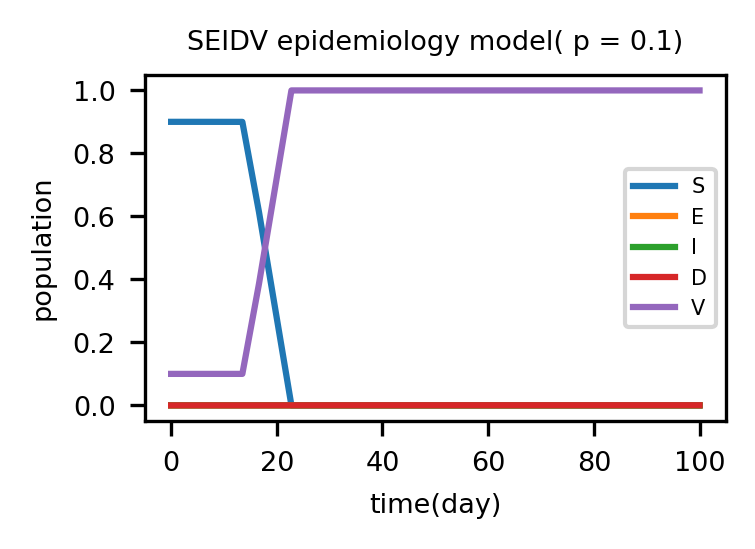

In [7]:
p_exp = 0.1                                                                     #Here we plot an example of SEIDV ODEs solutions, assuming that 10% of population are pre-vaccinated.
model , time = epidemiology_model(p_exp)
fig, ax = plt.subplots(1, 1, figsize=(2.5,1.5) ) 
ax.plot(time,model[0] , label = 'S')
ax.plot(time,model[1], label = 'E')
ax.plot(time,model[2], label = 'I')
ax.plot(time,model[3], label = 'D')
ax.plot(time,model[4], label = 'V')
ax.set_ylabel('population')
ax.set_xlabel('time(day)')
ax.set_title('SEIDV epidemiology model( p = {0})'.format(str(p_exp)))
ax.legend()
plt.show()

##$ϕ_s(p)$ function (probability that a delayer becomes infected with smallpox after an attack depending on the proportion p of the population, that is vaccinated preemptively)

In [8]:
def Phi_s(p):                                                                   #We define phi_s(p) probability that a delayer becomes infected with smallpox after an attack
  model , time = epidemiology_model(p)                                          
  Phi = (model[3][-1]) /(1 - model[4][0])
  return Phi

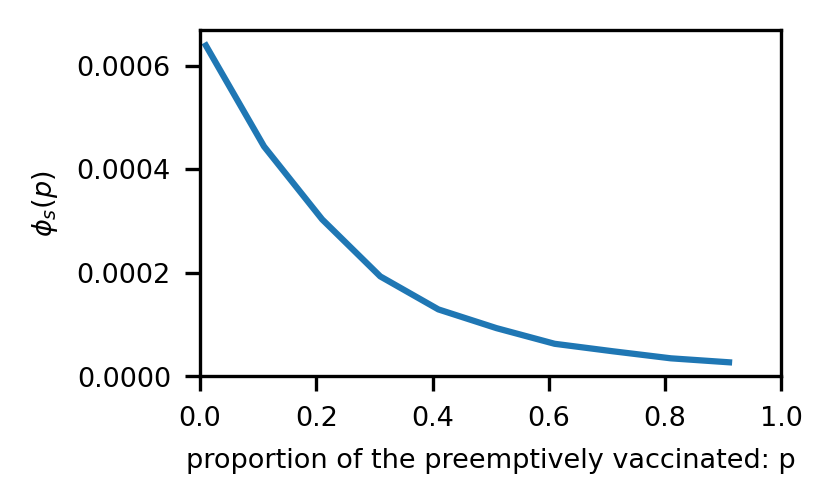

In [12]:
Phi_s_test = []
p_list_test = np.arange(0.01,1.01,0.1)
for i in p_list_test:
  Phi_s_test.append(Phi_s(i))


fig, ax = plt.subplots(1, 1, figsize=(2.5,1.5) ) 
ax.plot(p_list_test,Phi_s_test )
ax.set_ylabel('$\phi_s(p)$')
ax.set_xlabel('proportion of the preemptively vaccinated: p')
ax.set_xlim(0,1)
ax.set_ylim(0)
plt.show()


As we expected the $\phi_s(p)$ is a strictly decreasing function of p.

# Individual and group equilibrium:
We define pay-offs for the vaccinated and delayers($E_{vac}$ and $E_{del}$) and cost function( C(p) ) for the group optimum as it is defined in the paper.

Then we define two functions for calculating the individual and group optimum:

*   It finds individual optimum $P_{ind}$ by solving the $E_{vac} = E_{del}(P_{ind})$ equation. 

*   For the group optimum $p_{gr}$ we find the probability related to the minimum value of the cost function(C(p))


After finding the optimums we can find the difference between the group and individual optimum $Δp =  p_{gr} - p_{ind}$ and relative difference in expected mortality $ΔC/C = [C(p_{ind})-C(p_{gr})]/C(p_{gr}) $ and define them as seperate functions



In [14]:
def E_vac():
  return -d_v

def E_del(p):
  return -r*(Phi_s(p)*d_s + (1-Phi_s(p)) * d_v)

def C(p):
  return -p * E_vac() - (1-p) * E_del(p)

def mortality_rate(p,typ):
  if typ == 'ind':
    if E_vac() > E_del(0):
      return d_v
    else:
      return -E_del(0)
  elif typ == 'gr':
      return p * d_v + r * (1-p)*( (d_s - d_v) * Phi_s(p) + d_v )

def p_group():
  p_list = np.arange(0,0.999,0.001)
  dp = p_list[1]-p_list[0]
  cp = np.array([C(p_list[i]) for i in range(len(p_list))])
  return p_list[np.argmin(cp)]


def p_individual():
  phi_s_ind =(d_v*(1-r))/(r*(d_s-d_v))
  if E_vac() > E_del(0):
    p_list = np.arange(0.001,0.999,0.001)
    phi_list = np.array( [Phi_s(p_list[i]) for i in range(len(p_list))])
    intersection = np.where(abs(np.array(phi_list)-phi_s_ind) < 0.00001)[0]
    if len(intersection) > 0:
      return p_list[int(np.mean(np.where(abs(np.array(phi_list)-phi_s_ind) < 0.00001)[0]))]
    else:
      return 1
  else:
    return 0

def delta_p():
  return p_group() - p_individual()

def delta_C():
  return (C(p_individual()) - C(p_group()))/ C(p_group())

Now we reproduce the paper redults and find the $P_{ind}$ and $P_{gr}$, $Δp$ and $ΔC/C$ with the constants as they were defined in the 3rd column of the table.1 in the paper.

In [15]:
R0 = 5                                                                          ###Basic reproductive ratio
sigma = 1 / 11                                                                  ###1/Mean latent period
gamma = 1 / 3                                                                   ###1/Mean infectious period
t_res = 14                                                                      ###Vaccinator response time
nu = 0.10                                                                       ###Vaccination rate
d_v = pow(10,-6)                                                                ###Probability of death from vaccine
d_s = 0.3                                                                       ###Probability of death from smallpox
r = 0.01                                                                        ###Attack risk (probability)
alpha = 5000/290000000                                                          ###Attack size (no. of individuals)
beta = gamma * R0                                                               ###Mean transmission rate 
N = 1                                                                           ###total population
print('p_gr =',round(p_group(),2),'\np_ind =' ,round(p_individual(),2))
print('\u0394p =',round(delta_p(),2),'\n\u0394C/C=' ,round(delta_C(),2))

p_gr = 0.48 
p_ind = 0.18
Δp = 0.3 
ΔC/C= 0.54


The results that the paper reported are: $P_{ind} = 0.19$, $P_{gr} = 0.47$ and $ΔC/C = 0.54$. As we can see they are very close to our results.

#Vaccination coverage in a range of reproductive ratios $R_0$
In this part we investigate the effect of the reproductive ratio on the value of the group and individual optimum and the mortality due to them.(The same as the Fig.2(first row) in the paper).
All the constants are as before, but the $R_0 \in [1,10]$.

In [ ]:
R0_list = np.arange(1,10,0.3)                                                   ###Basic reproductive ratio range
sigma = 1 / 11                                                                  ###1/Mean latent period
gamma = 1 / 3                                                                   ###1/Mean infectious period
t_res = 14                                                                      ###Vaccinator response time
nu = 0.10                                                                       ###Vaccination rate
d_v = pow(10,-6)                                                                ###Probability of death from vaccine
d_s = 0.3                                                                       ###Probability of death from smallpox
r = 0.01                                                                        ###Attack risk (probability)
alpha = 5000/290000000                                                          ###Attack size (no. of individuals)
beta = gamma * R0                                                               ###Mean transmission rate 
N = 1                                                                           ###total population


R_p_gr = []
R_p_ind = []
for R0 in R0_list:
  # print(R0)
  beta = gamma * R0 
  R_p_gr.append(p_group())
  R_p_ind.append(p_individual())



In [ ]:
interval = 1
R_bad_results_gr = np.where(np.array(R_p_gr)>=1)[0]
R_p_gr_corrected = [R_p_gr[i] for i in range(len(R_p_gr)) if (i in R_bad_results_gr) == False ]
R_mean_p_gr = [np.mean(R_p_gr_corrected[i-interval:interval+i]) for i in range(interval,len(R_p_gr_corrected)-interval)]
R0_list_gr = np.array([R0_list[i]  for i in range(len(R0_list)) if (i in R_bad_results_gr) == False])[interval:len(R_p_gr_corrected)-interval]

R_bad_results_ind = np.where(np.array(R_p_ind)>=1)[0]
R_p_ind_corrected = [R_p_ind[i]  for i in range(len(R_p_ind)) if (i in R_bad_results_ind) == False]
R_mean_p_ind = [np.mean(R_p_ind_corrected[i-interval:interval+i]) for i in range(interval,len(R_p_ind_corrected)-interval)]
R0_list_ind = np.array([R0_list[i]  for i in range(len(R0_list)) if (i in R_bad_results_ind) == False])[interval:len(R_p_ind_corrected)-interval]


In [ ]:
fig ,ax = plt.subplots(1, 1 , figsize = (2.5,1))
ax.plot(R0_list_gr,R_mean_p_gr , '--',label='p_gr')
ax.plot(R0_list_ind,R_mean_p_ind,label='p_ind')
ax.set_xlabel('Reproductive ratio: $R_0$')
ax.set_ylabel('Coverage')
ax.set_xlim(1,9)
ax.set_ylim(0,0.8)
ax.legend()

plt.show()

#Vaccination coverage in a range of vaccination rates $\nu$
In this part we investigate the effect of the vaccination rate on the value of the group and individual optimum and the mortality due to them.(The same as the Fig.2(second row) in the paper).
All the constants are as before, but the $\nu \in [0.02,0.14]$.

In [ ]:
R0 = 5                                                                          ###Basic reproductive ratio
sigma = 1 / 11                                                                  ###1/Mean latent period
gamma = 1 / 3                                                                   ###1/Mean infectious period
t_res = 14                                                                      ###Vaccinator response time
nu_list = np.arange(0.0095,0.15,0.005)                                          ###Vaccination rate range
d_v = pow(10,-6)                                                                ###Probability of death from vaccine
d_s = 0.3                                                                       ###Probability of death from smallpox
r = 0.01                                                                        ###Attack risk (probability)
alpha = 5000/290000000                                                          ###Attack size (no. of individuals)
beta = gamma * R0                                                               ###Mean transmission rate 
N = 1                                                                           ###total population


nu_p_gr = []
nu_p_ind = []
for nu in nu_list:
  # print(nu)
  nu_p_gr.append(p_group())
  nu_p_ind.append(p_individual())


In [ ]:
interval = 2
nu_bad_results_gr = np.where(np.array(nu_p_gr)>=1)[0]
nu_p_gr_corrected = [nu_p_gr[i] for i in range(len(nu_p_gr)) if (i in nu_bad_results_gr) == False ]
nu_mean_p_gr = [np.mean(nu_p_gr_corrected[i-interval:interval+i]) for i in range(interval,len(nu_p_gr_corrected)-interval)]
nu_list_gr = np.array([nu_list[i]  for i in range(len(nu_list)) if (i in nu_bad_results_gr) == False])[interval:len(nu_p_gr_corrected)-interval]

nu_bad_results_ind = np.where(np.array(nu_p_ind)>=1)[0]
nu_p_ind_corrected = [nu_p_ind[i]  for i in range(len(nu_p_ind)) if (i in nu_bad_results_ind) == False]
nu_mean_p_ind = [np.mean(nu_p_ind_corrected[i-interval:interval+i]) for i in range(interval,len(nu_p_ind_corrected)-interval)]
nu_list_ind = np.array([nu_list[i]  for i in range(len(nu_list)) if (i in nu_bad_results_ind) == False])[interval:len(nu_p_ind_corrected)-interval]

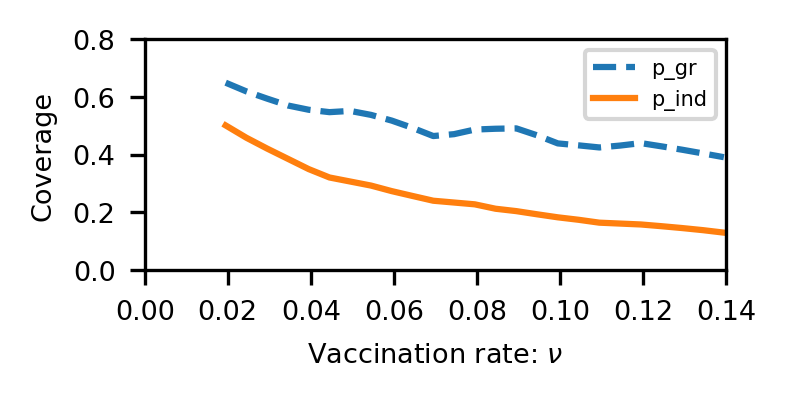

In [ ]:
fig ,ax = plt.subplots(1, 1 , figsize = (2.5,1))
ax.plot(nu_list_gr,nu_mean_p_gr , '--',label='p_gr')
ax.plot(nu_list_ind,nu_mean_p_ind,label='p_ind')
ax.set_xlabel('Vaccination rate: $\u03BD$')
ax.set_ylabel('Coverage')
ax.set_xlim(0,0.14)
ax.set_ylim(0,0.8)
ax.legend()

plt.show()

#Vaccination coverage in a range of attack risks r
In this part we investigate the effect of the attack risk r on the value of the group and individual optimum and the mortality due to them.(The same as the Fig.2(third row) in the paper).
All the constants are as before, but the $r \in [0.001,0.05]$.

In [ ]:
R0 = 5                                                                          ###Basic reproductive ratio
sigma = 1 / 11                                                                  ###1/Mean latent period
gamma = 1 / 3                                                                   ###1/Mean infectious period
t_res = 14                                                                      ###Vaccinator response time
nu = 0.10                                                                       ###Vaccination rate
d_v = pow(10,-6)                                                                ###Probability of death from vaccine
d_s = 0.3                                                                       ###Probability of death from smallpox
r_list = np.arange(0.00001,0.032,0.001)                                          ###Attack risk (probability)
alpha = 5000/290000000                                                          ###Attack size (no. of individuals)
beta = gamma * R0                                                               ###Mean transmission rate 
N = 1                                                                           ###total population


r_p_gr = []
r_p_ind = []
for r in r_list:
  # print(r)
  r_p_gr.append(p_group())
  r_p_ind.append(p_individual())


In [ ]:
r_bad_results_gr = np.where(np.array(r_p_gr)>=1)[0]
r_p_gr_corrected = [r_p_gr[i] for i in range(len(r_p_gr)) if (i in r_bad_results_gr) == False ]
r_list_gr = np.array([r_list[i]  for i in range(len(r_list)) if (i in r_bad_results_gr) == False])

r_bad_results_ind = np.where(np.array(r_p_ind)>=1)[0]
r_p_ind_corrected = [r_p_ind[i]  for i in range(len(r_p_ind)) if (i in r_bad_results_ind) == False]
r_list_ind = np.array([r_list[i]  for i in range(len(r_list)) if (i in r_bad_results_ind) == False])

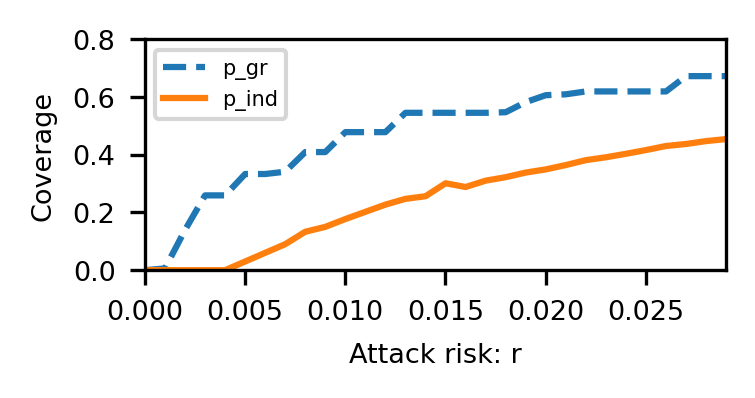

In [ ]:
fig ,ax = plt.subplots(1, 1 , figsize = (2.5,1))
ax.plot(r_list_gr,r_p_gr_corrected , '--',label='p_gr')
ax.plot(r_list_ind,r_p_ind_corrected,label='p_ind')
ax.set_xlabel('Attack risk: r')
ax.set_ylabel('Coverage')
ax.set_ylim(0,0.8)
ax.set_xlim(0,0.029)
ax.legend()

plt.show()

These plots are very close to the plots from the paper. In all these plots, the vaccination level that assures the herb immunity is higher than the vaccination level that will be achieved with the self-interset policy.